# Titanic Survival Random Forest Model

In this notebook I predict the survival of passengers on the titanic.
The dataset is given in the form of two CSV files consisting of tabulated passenger info with no overlap.
The first is the training set of around 800 passengers and test set of around 400 passengers.
There are a total of one indexing column "PassengerId", one target column "Survived", and ten predictor columns.

## Methodology and Goals

My approach was to keep the model and transformations fairly simple, so I chose to apply a **random forest classifier**.
This selection of a RFC was also motivated by the fact that most predictor columns were categorical or could be transformed to categorical data
and the relative sparsity of one column "Cabin."
Initial data exploration demonstrated "Sex" as a good predictor of survival rates.
I expected "Cabin" to be a useful predictor, but only about one-fourth of the entries were filled.
This was remedied by more categorical encoding.

Coding-wise, it was my intention to have Pandas and Scikit-learn do all the heavy-lifting.
A little more polish is needed such as moving some hard-coded parameters outside the functions in which they are define

The final results are 0.83 ACC for the training set and 0.80 ACC for the test set which was my initial hope for total accuracy of such a simple model.

In [1]:
import os
import sys
import pandas as pd
import re
import numpy as np

import sklearn.tree as tree
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.metrics
import sklearn.preprocessing

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline

In [2]:
plotly.offline.init_notebook_mode(connected=True)

data_name = "data"
train_bn = "train.csv"
test_bn = "test.csv"

proj_dir = os.path.abspath(
        os.path.join(os.path.abspath(__name__), os.pardir, os.pardir)
)
data_dir = os.path.join(proj_dir, data_name)
train_fn = os.path.join(data_dir, train_bn)
test_fn = os.path.join(data_dir, test_bn)

if not os.path.exists(data_dir):
    raise OSError("Data directory not properly setup.")

In [3]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = None

## Import extension of Sklearn encoder to fit to out-of-sample categories

In [4]:
external_library = os.path.abspath(
    os.path.join(
        os.path.abspath(__name__),
        os.pardir, os.pardir, os.pardir, os.pardir,
        "code_blocks", "data_science_utilities",
    )
)

if os.path.exists(external_library):
    sys.path.append(external_library)
else:
    raise ValueError()

import preprocessing.encoder_ext as encoder_ext

In [5]:
try: 
    df_train = pd.read_csv(train_fn)
except OSError as e:
    print("Training file missing.")
try:
    df_test = pd.read_csv(test_fn)
except OSError as e:
    print("Test file missing.")

In [6]:
name = "Name"
sex = "Sex"
emb = "Embarked"
cabin = "Cabin"
age = "Age"
fare = "Fare"
ticket = "Ticket"
sib = "SibSp"
par = "Parch"
pclass = "Pclass"
ticket_count = "ticket_count"
num_cab = "num_cab"

family = "family"
fam_size = "fam_size"
fam_per_ticket = "fam_per_ticket"
single = "single"
child = "child"

pid = "PassengerId"
survived = "Survived"

dummy_cols = [
        pclass, 
        fam_size,
        name, 
        cabin, 
        emb,
        num_cab,
        fare,
        age,
]

dep_vars = [survived]
indices = [pid]
ind_vars = [
    x for x in df_train.columns if x not in (dep_vars+indices+[ticket])
]

In [7]:
df_X = pd.concat([df_train, df_test], ignore_index=True)

In [8]:
df_X.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
pd.DataFrame(df_train.count())

,0
PassengerId,891
Survived,891
Pclass,891
Name,891
Sex,891
Age,714
SibSp,891
Parch,891
Ticket,891
Fare,891


In [10]:
pd.DataFrame(df_test.count())

,0
PassengerId,418
Pclass,418
Name,418
Sex,418
Age,332
SibSp,418
Parch,418
Ticket,418
Fare,417
Cabin,91


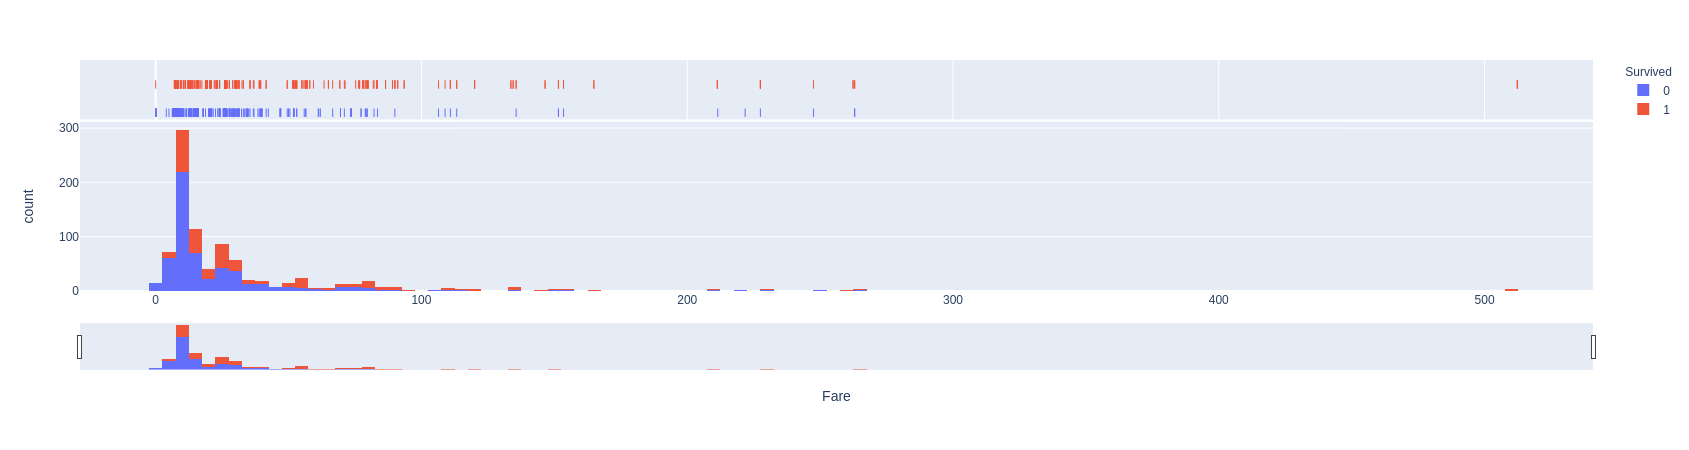

In [11]:
fig = px.histogram(
    df_train,
    x=fare,
    color=survived,
    marginal="rug", 
    nbins=200,
    hover_data=df_train.columns,
)
fig.update_layout(
    go.Layout(
        xaxis = dict(
            rangeslider = {'visible': True},
        ),
    )
)
plotly.offline.iplot(fig)

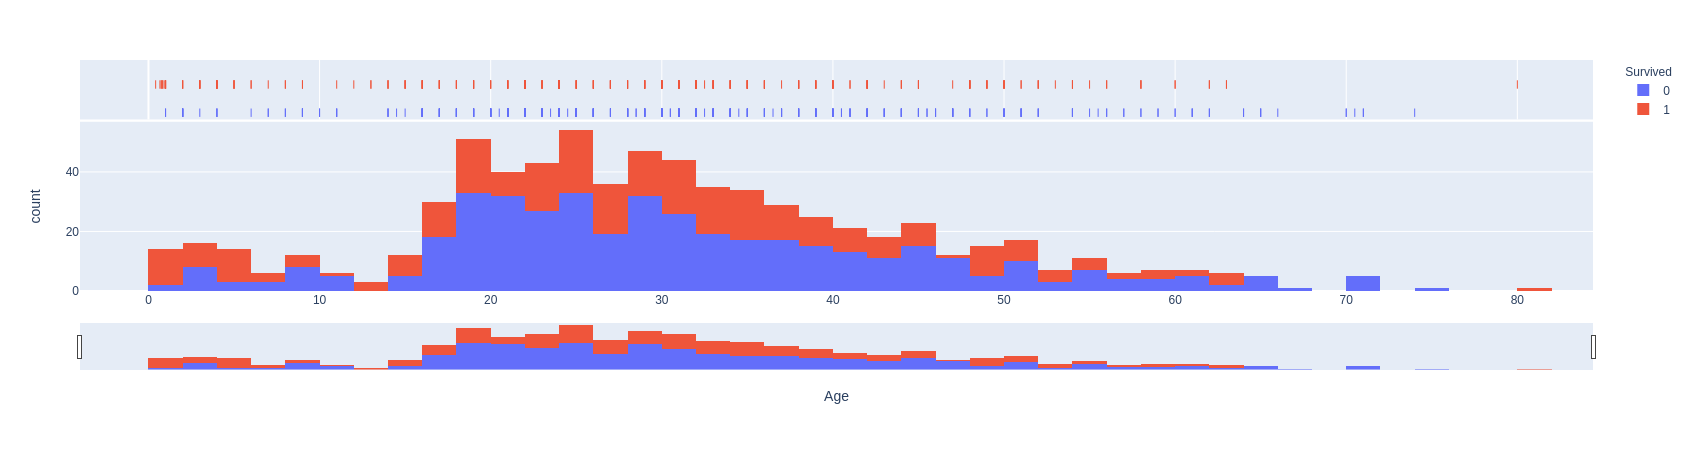

In [12]:
fig = px.histogram(
    df_train,
    x=age,
    color=survived,
    marginal="rug", 
    nbins=50,
    hover_data=df_train.columns,
)
fig.update_layout(
    go.Layout(
        xaxis = dict(rangeslider={'visible': True}),
    )
)
plotly.offline.iplot(fig)

In [13]:
def pre_encoding(df):
    """
    """
    reg_ex = "\w+\s?\w*(\.)"
    reg = re.compile(reg_ex)
    cabin_mapping = {
        '': '',
        'A': 'A',
        'B': 'B',
        'C': 'B',
        'D': 'D',
        'E': 'D',
        'F':'F',
        'G': 'F',
        'T': 'A',
    }
    f_size = {
        1: 0,
        2: 1,
        3: 1,
        4: 2,
        5: 2, 
        6: 3,
        7: 3,
        8: 4,
        9: 4,
        10: 4,
        11: 4,
    }
    
    df[sex] = df[sex].apply(lambda x: x[0] if len(x) > 0 else '')
    
    df[name] = (
        df[name]
            .apply(lambda x: x.split(',')[1].strip())
            .apply(lambda x: reg.match(x).group())
    )
    
    thresh = 0.01
    UNK = "UNK"
    freq = df[name].value_counts(normalize=True)
    df[name] = (
        df[name]
            .apply(lambda x: x if freq[x] >= thresh else UNK)
    )
    
    tmp = df.groupby(ticket).count()
    df[ticket_count] = df[ticket].apply(lambda x: tmp.at[x, pid])

    df[cabin] = df[cabin].fillna('')
    df.loc[df[cabin].notnull(), num_cab] = (
        df.loc[df[cabin].notnull(), cabin]
            .apply(lambda x: len(x.split()))
    ) 
    
    combine_decks = lambda x: cabin_mapping[x]
    df.loc[df[cabin].notnull(), cabin] = (
        df.loc[df[cabin].notnull(), cabin]
            .apply(lambda x: x[0] if len(x) > 0 else '')
            .apply(combine_decks)
    )
    
    df[family] = df[par] + df[sib] + 1
    df[fam_per_ticket] = df[family]/df[ticket_count]

    df[ticket] = (
        df[ticket]
            .apply(lambda x: 1 if (len(x.split())>1) else 0) 
    )
    
    df[single] = df[family].apply(lambda x: 1 if x==1 else 0)
    
    df[fam_size] = df[family].apply(lambda x: f_size[x])

    return 0

In [14]:
def build_encoders(df):
    """
    """
    enc_name = encoder_ext.LabelEncoderExt()
    enc_sex = sklearn.preprocessing.LabelEncoder()
    enc_emb = sklearn.preprocessing.LabelEncoder()
    enc_cabin = sklearn.preprocessing.LabelEncoder()

    enc_name.fit(df[name])
    enc_sex.fit(df[sex].dropna())
    enc_emb.fit(df[emb].dropna())
    enc_cabin.fit(df[cabin].dropna())
    enc_dict = {name: enc_name, sex: enc_sex, emb: enc_emb, cabin: enc_cabin}
 
    scl_age = sklearn.preprocessing.StandardScaler()
    scl_age.fit(df[[age]].dropna().values)
    scl_fare = sklearn.preprocessing.StandardScaler()
    scl_fare.fit(df[[fare]].dropna().values)
    scl = {age: scl_age, fare: scl_fare}
        
    return enc_dict, scl

In [15]:
def scale(df, scl):
    """
    """
    df.loc[df[age].notnull(), age] = (
            scl[age].transform(df[[age]].dropna().values)
    )
    df.loc[df[fare].notnull(), fare] = (
            scl[fare].transform(df[[fare]].dropna().values)
    )    
    return 0

In [16]:
def naive_bayes_data_fill(df, enc_dict):
    """
    """
    df.loc[df[emb].notnull(), emb] = (
            enc_dict[emb].transform(df[emb].dropna().values)
    )
    df.loc[:, sex] = enc_dict[sex].transform(df[sex].values)
    df.loc[df[cabin].notnull(), cabin] = (
            enc_dict[cabin].transform(df[cabin].dropna().values)
    )
    df.loc[:, name] = enc_dict[name].transform(df[name].values)
    
    criteria = [pclass, sex, par] 
    tmp = df[criteria+[emb]].dropna()
    index = df.index.isin(tmp.index)
    
    X = tmp[criteria].values.astype(np.int)
    Y = tmp[emb].values.astype(np.int)
    tmp2 = df.loc[~index, criteria]
    if len(tmp2) > 0:
        clf = sklearn.naive_bayes.MultinomialNB()
        clf.fit(X, Y)
        df.loc[~index, emb] = clf.predict(tmp2)
    
    return 0

In [17]:
def mean_data_fill(df):
    """
    """
    group = [pclass, emb]
    nan_fares = df[fare].isnull()
    
    tmp = df.groupby(group).mean()[[fare]]
    tmp2 = df.loc[nan_fares][group]
    ind = pd.MultiIndex.from_arrays(tmp2.values.T, names=tmp.index.names)
    df.loc[nan_fares, fare] = tmp.loc[ind, fare].fillna(0).values
    
    group = [name, pclass, sex]
    nan_ages = df[age].isnull()
    
    tmp1 = df.groupby(group).mean()[[age]]
    tmp2 = df.loc[nan_ages][group]
    ind = pd.MultiIndex.from_arrays(tmp2.values.T, names=tmp1.index.names)
    df.loc[nan_ages, age] = tmp1.loc[ind, age].fillna(0).values

    return 0

In [18]:
def discretize(df, age_bins=10, fare_bins=6):
    """
    """
    df[age] = pd.cut(df_X[age], bins=age_bins, 
                     labels=np.arange(0, age_bins))
    df[fare] = pd.cut(df_X[fare], bins=fare_bins, 
                     labels=np.arange(0, fare_bins))
    return 0

In [19]:
def preprocess(df, enc_dict=None, scl=None):
    """
    """
    pre_encoding(df)
    if enc_dict is None:
        enc_dict, scl = build_encoders(df)
    scale(df, scl)
    naive_bayes_data_fill(df, enc_dict)
    
    mean_data_fill(df)
    discretize(df)
    
    return enc_dict, scl

In [20]:
enc_dict, scl = preprocess(df_X)

In [21]:
df_X.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ticket_count,num_cab,family,fam_per_ticket,single,fam_size
0,1,0.0,3,2,1,2,1,0,1,0,0,2,1,0,2,2.0,0,1
1,2,1.0,1,3,0,4,1,0,1,0,2,0,2,1,2,1.0,0,1
2,3,1.0,3,1,0,3,0,0,1,0,0,2,1,0,1,1.0,1,0
3,4,1.0,1,3,0,4,1,0,0,0,2,2,2,1,2,1.0,0,1
4,5,0.0,3,2,1,4,0,0,0,0,0,2,1,0,1,1.0,1,0


In [22]:
df_X.drop([ticket, par, sib, family, fam_per_ticket], axis=1, inplace=True)

In [23]:
df_train = df_X.iloc[:df_train.shape[0]]
df_test = df_X.iloc[df_train.shape[0]:]

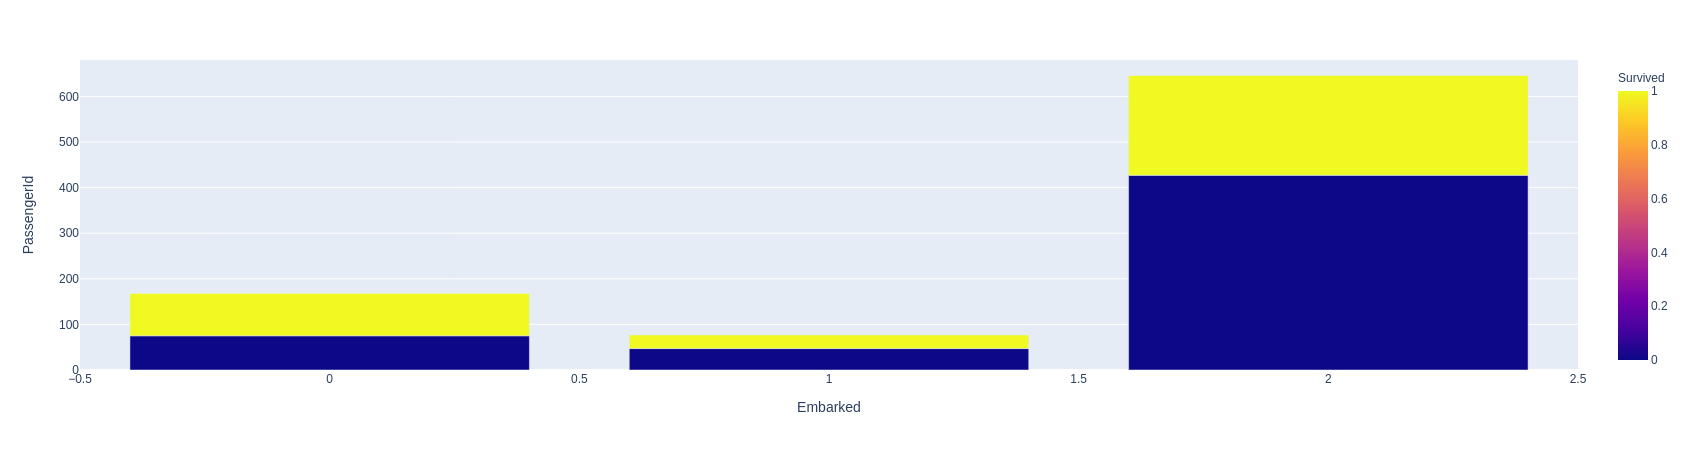

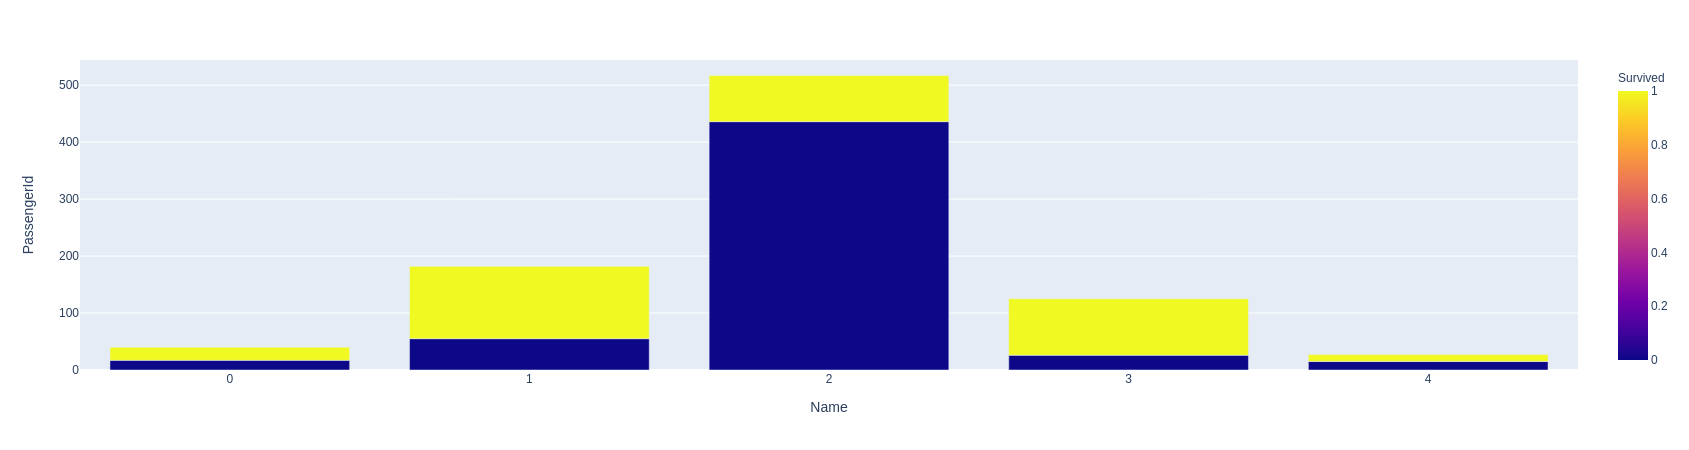

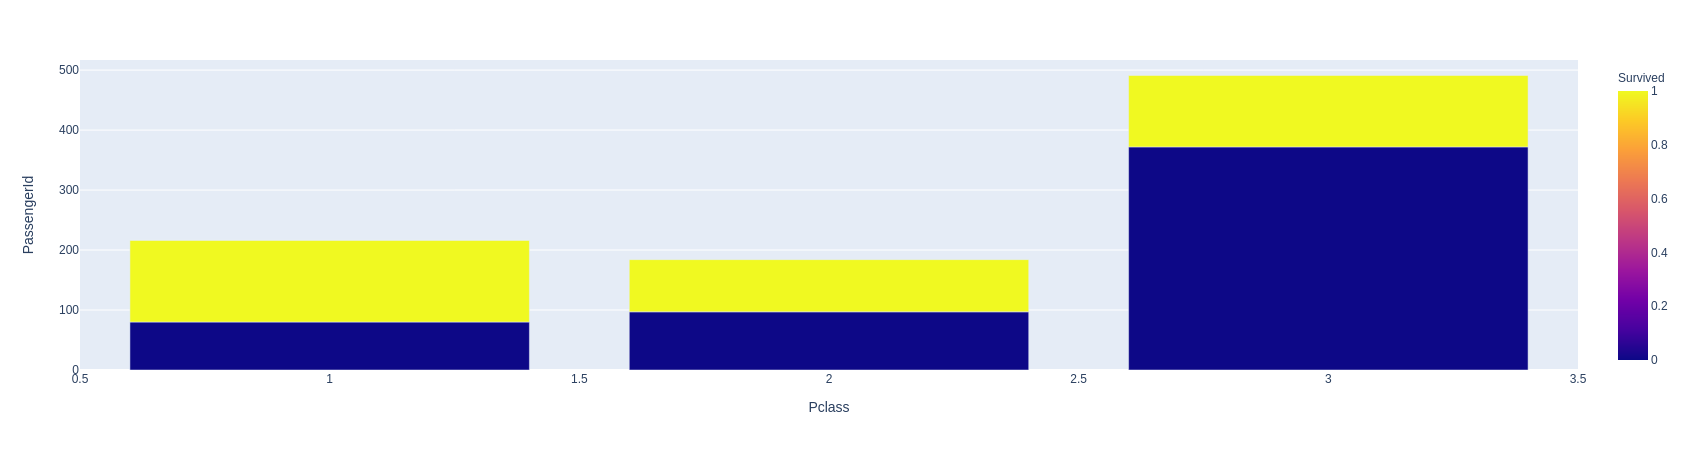

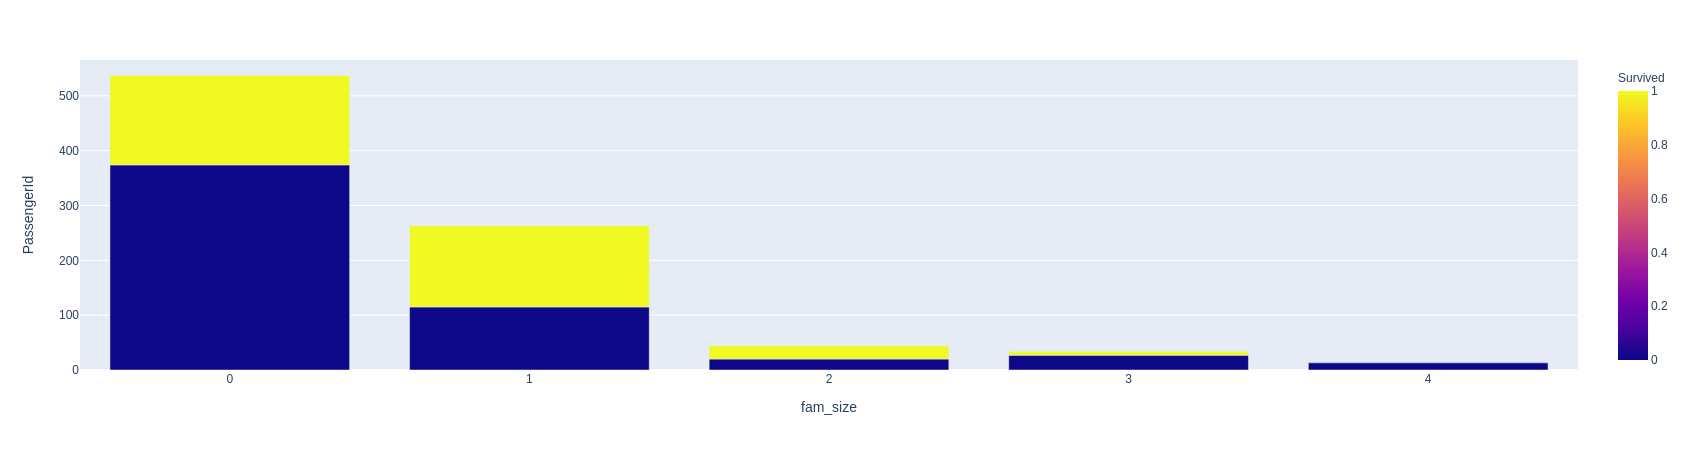

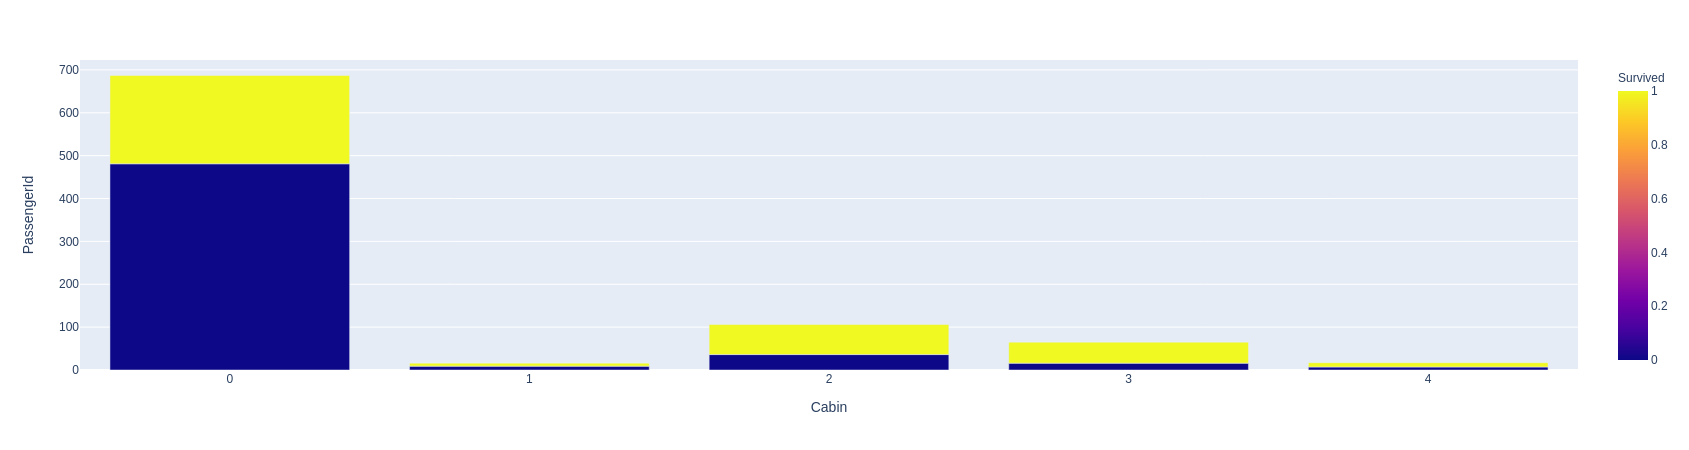

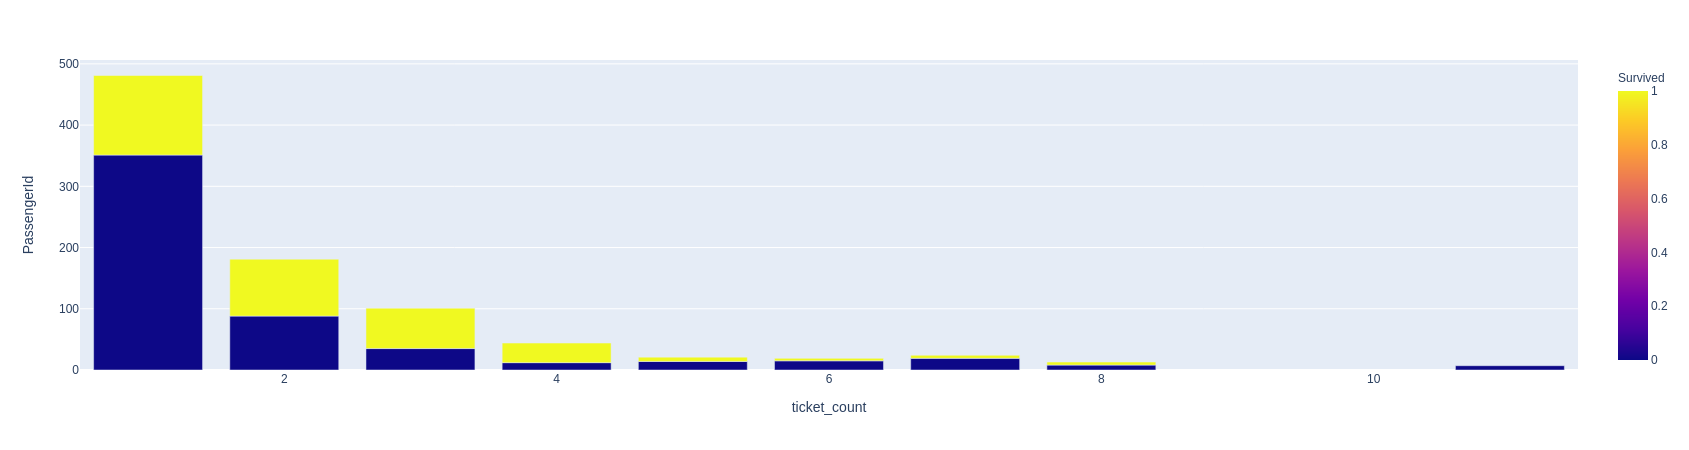

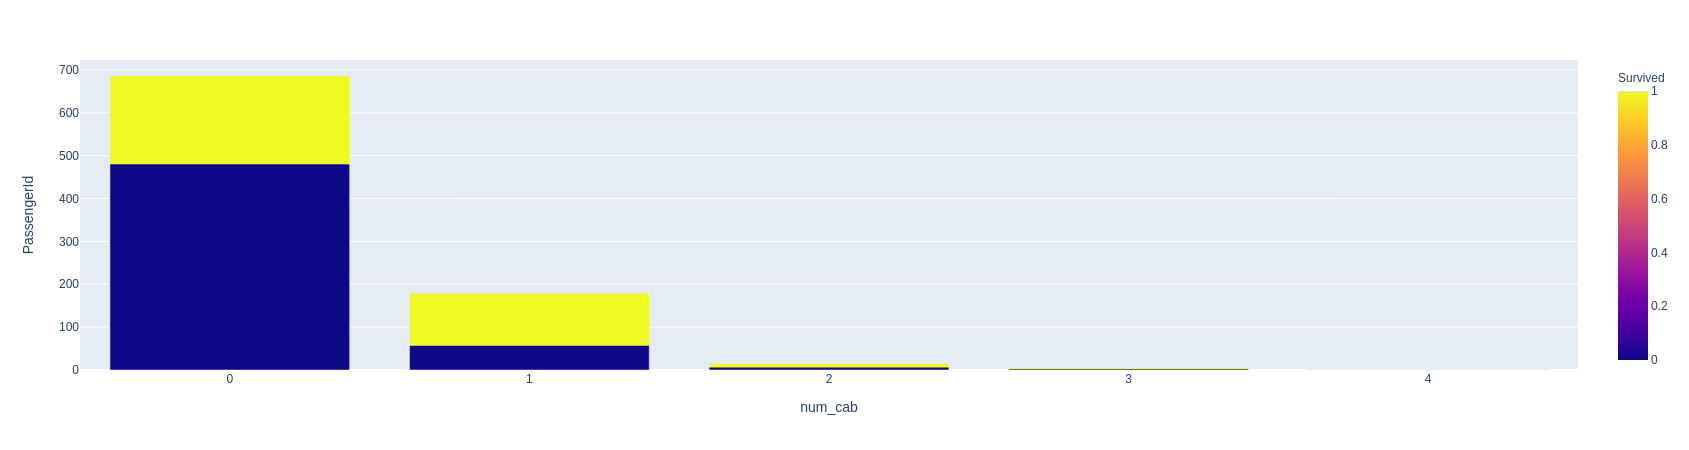

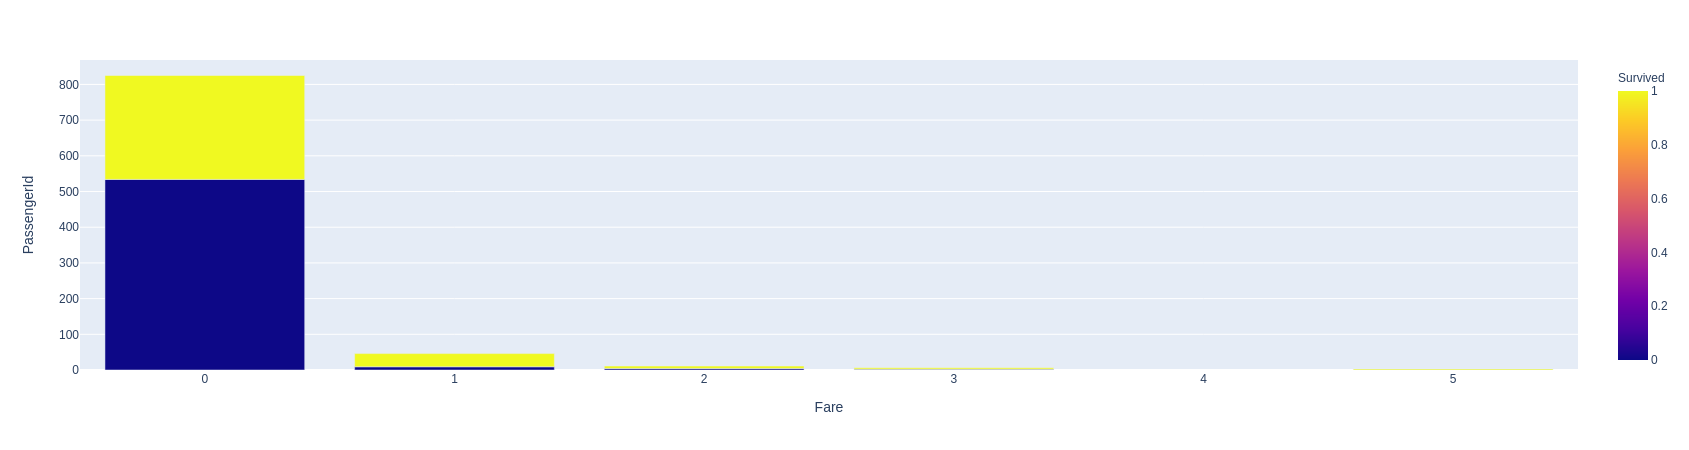

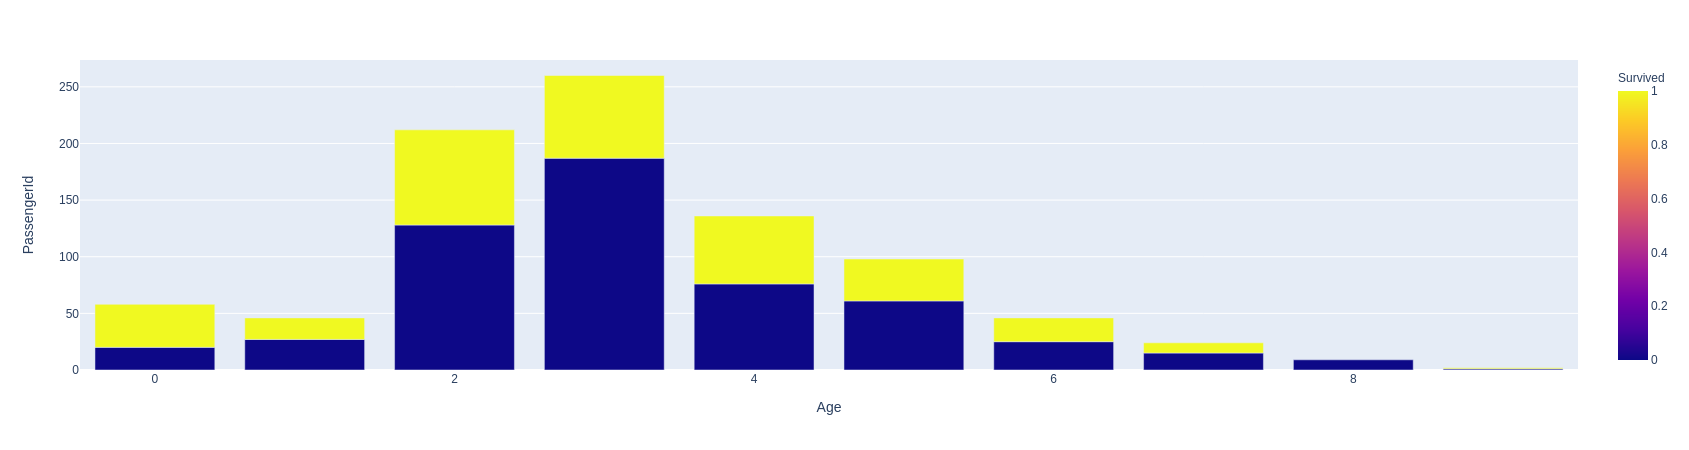

In [24]:
feat_list = [
    emb, 
    name, 
    pclass, 
    fam_size, 
    cabin,
    ticket_count,
    num_cab,
    fare,
    age,
]

for feat in feat_list:
    df_tmp = df_train.groupby([feat, survived]).count().reset_index()
    fig = px.bar(df_tmp, x=feat, y=pid, color=survived)
    plotly.offline.iplot(fig)

In [25]:
X_train = (
    pd.get_dummies(
        df_train, 
        columns=dummy_cols
    ).drop(dep_vars+indices, axis=1)
)
X_test = (
    pd.get_dummies(df_test, columns=dummy_cols)
        .drop(indices, axis=1)
)

X_test = X_test.join(
    pd.DataFrame(
        {x: 0 for x in X_train.columns if x not in X_test.columns}, 
        index=X_test.index,
    )
)
X_test = X_test[X_train.columns]

Y_train = df_train[dep_vars]

In [26]:
SEED = 0
np.random.seed(seed=SEED)

clf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    criterion="gini",
    min_samples_split=3,
    min_samples_leaf=5,
)
clf.fit(X_train, Y_train.values.ravel())

pred = clf.predict(X_test)
results = (
    pd.DataFrame(
        {indices[0]: df_test[indices[0]].values, dep_vars[0]: pred}
    )
        .astype({survived: int})
)

In [27]:
output_dir = data_dir
results_bn = "results.csv"
results_fn = os.path.join(output_dir, results_bn)

In [28]:
results.to_csv(results_fn, index=False)

In [29]:
acc = sklearn.metrics.accuracy_score(Y_train, clf.predict(X_train))
print(f"Accuracy: {acc}")

Accuracy: 0.835016835016835


In [30]:
pd.DataFrame(sklearn.metrics.confusion_matrix(Y_train, clf.predict(X_train)))

,0,1
0,497,52
1,95,247


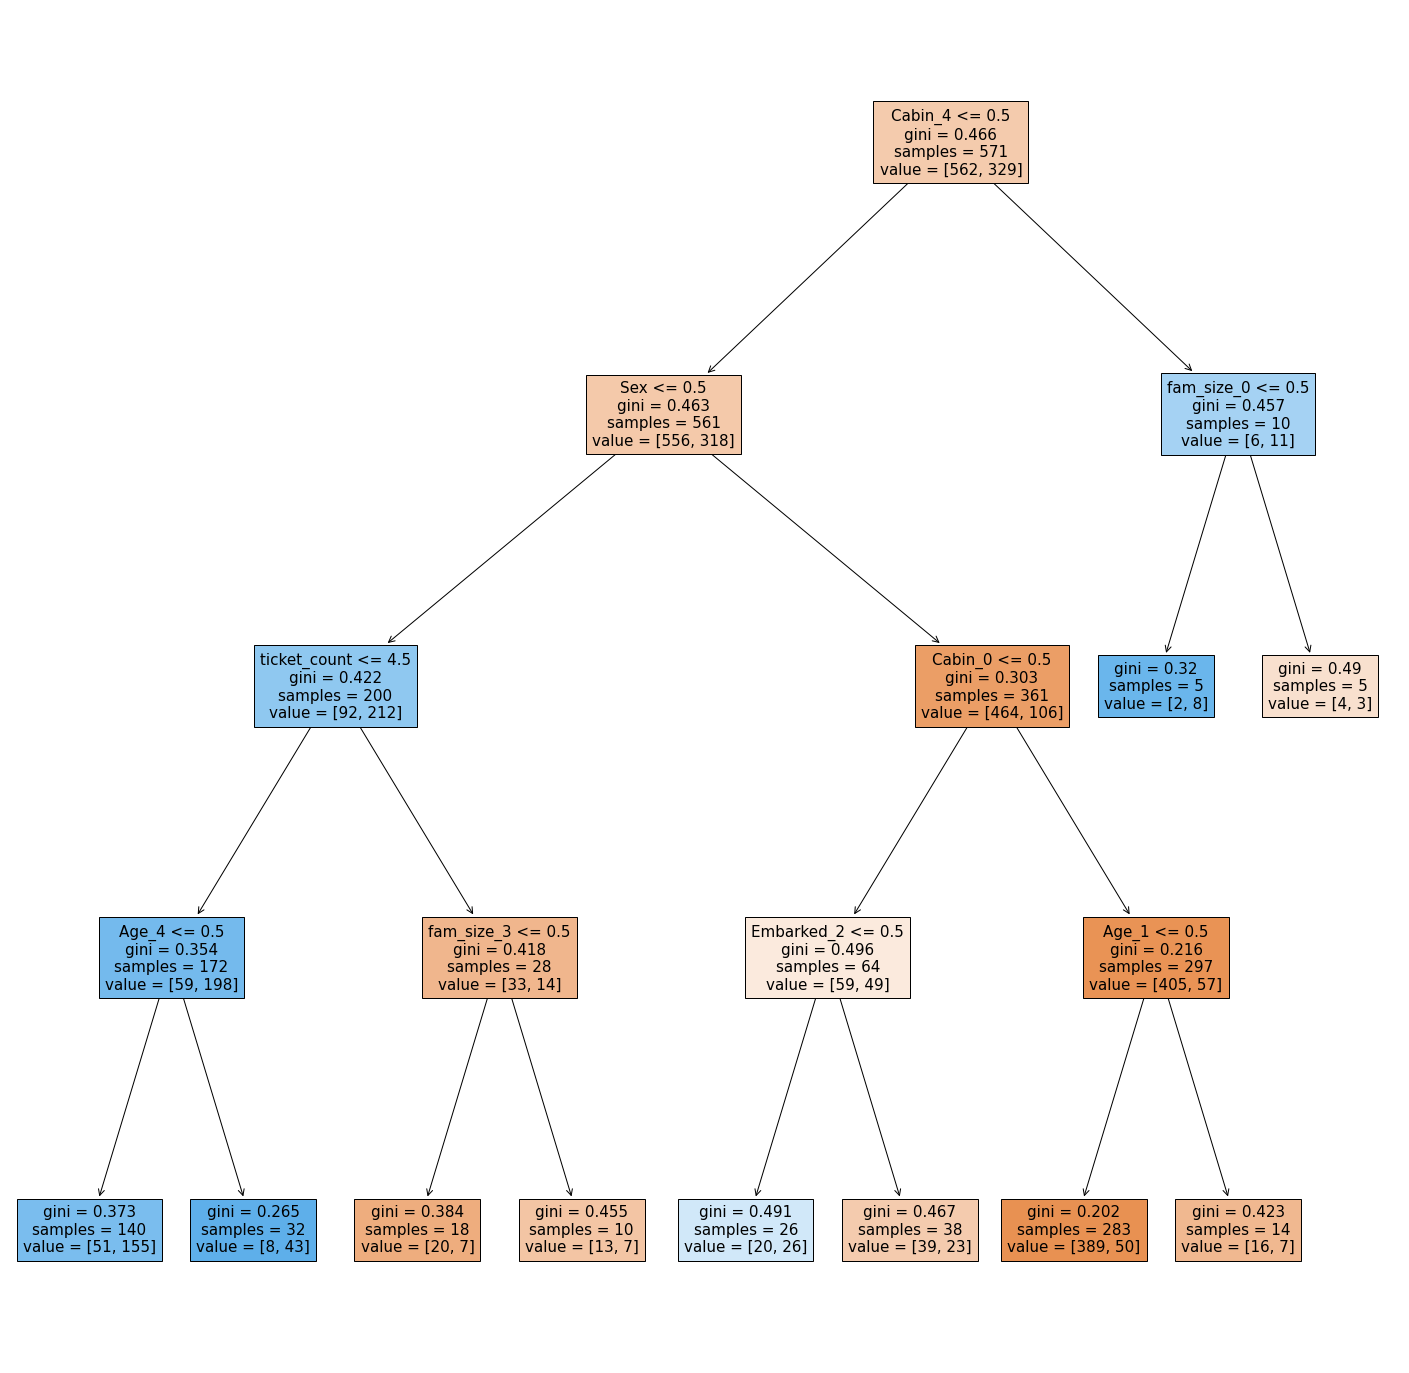

In [31]:
estimator = clf.estimators_[0]

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot()
a = tree.plot_tree(estimator, feature_names=X_train.columns, filled=True)